##  Visualization of the Filters

### Import tensorflow and load the VGG19 model with weights pre-trained on Imagenet.

In [0]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

### Check model summary to see layer names and no.of filters in each layer

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Load given image

In [0]:
import matplotlib.pyplot as plt
import numpy as np

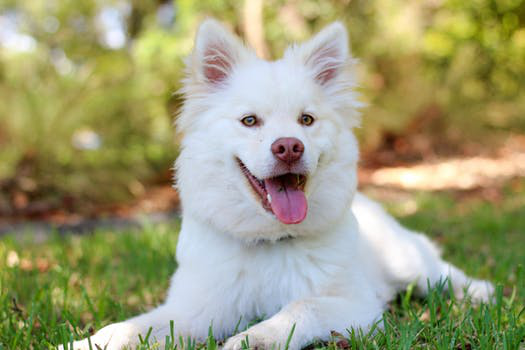

In [4]:
img = tf.keras.preprocessing.image.load_img('dog.jpeg')
img

In [0]:
#Prepare image prediction
img_array = tf.keras.preprocessing.image.img_to_array(img.resize((224, 224)))

#Normalize the image
img_array[:,:,0] -= 103.939
img_array[:,:,1] -= 116.779
img_array[:,:,2] -= 123.68

#Create a batch
img_array = np.expand_dims(img_array, axis=0)

### Get model Input

In [0]:
#Get model Input
input_img = model.input

### Get model output of layer with name `block1_conv1`

In [0]:
#Get Layer Output
layer_name = 'block5_conv1'
model_output = model.get_layer(layer_name).output

In [8]:
model_output

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

### Calculate Gradient for multiple filters


In [0]:
filters_info = []

In [25]:
K = tf.keras.backend

for i in range(64):
    
    print('Processing filter ', i , ' of layer ', layer_name)
    
    #Loss
    loss = K.mean(model_output[:,:,:,i])  #i is filter index
    
    #Gradient of loss w.r.t input image
    grads = K.gradients(loss, input_img)[0]

    #Gradient normalization
    grads /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    
    #Define function to run Graph
    iterate = K.function([input_img], [loss, grads])
    
    updated_img_input = img_array.copy()
    
    #Calculate Gradients and update input image
    for j in range(64):
        
        #Get loss and Gradients
        loss_value, grads_value = iterate([updated_img_input])
        
        #Update image with Gradients
        updated_img_input += grads_value
        
        #Ignore filters if loss value is stuck below zero
        if loss_value < 0:
            
            break
            
    if loss_value > 0:
        
        filters_info.append((i, updated_img_input[0]))   

Processing filter  0  of layer  block5_conv1
Processing filter  1  of layer  block5_conv1
Processing filter  2  of layer  block5_conv1
Processing filter  3  of layer  block5_conv1
Processing filter  4  of layer  block5_conv1
Processing filter  5  of layer  block5_conv1
Processing filter  6  of layer  block5_conv1
Processing filter  7  of layer  block5_conv1
Processing filter  8  of layer  block5_conv1
Processing filter  9  of layer  block5_conv1
Processing filter  10  of layer  block5_conv1
Processing filter  11  of layer  block5_conv1
Processing filter  12  of layer  block5_conv1
Processing filter  13  of layer  block5_conv1
Processing filter  14  of layer  block5_conv1
Processing filter  15  of layer  block5_conv1
Processing filter  16  of layer  block5_conv1
Processing filter  17  of layer  block5_conv1
Processing filter  18  of layer  block5_conv1
Processing filter  19  of layer  block5_conv1
Processing filter  20  of layer  block5_conv1
Processing filter  21  of layer  block5_conv

In [11]:
len(filters_info)

63

### Plot Images for each filter


In [0]:
filters_info.sort(key=lambda x: x[0], reverse=True)


### Deprocess image


In [0]:
def deprocess_image(x):
    
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    #x = np.clip(x, 0, 255).astype('uint32')
    
    return x

### Plot image of 4th filter

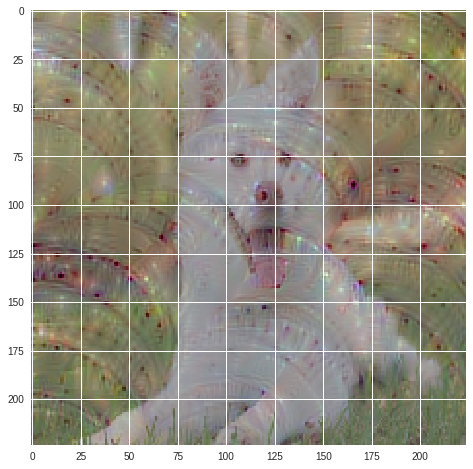

In [30]:
plt.figure(figsize=(8,8))
plt.imshow(deprocess_image(filters_info[4][1]))
plt.show()

### Plot all the images of 64 filters 

ValueError: ignored

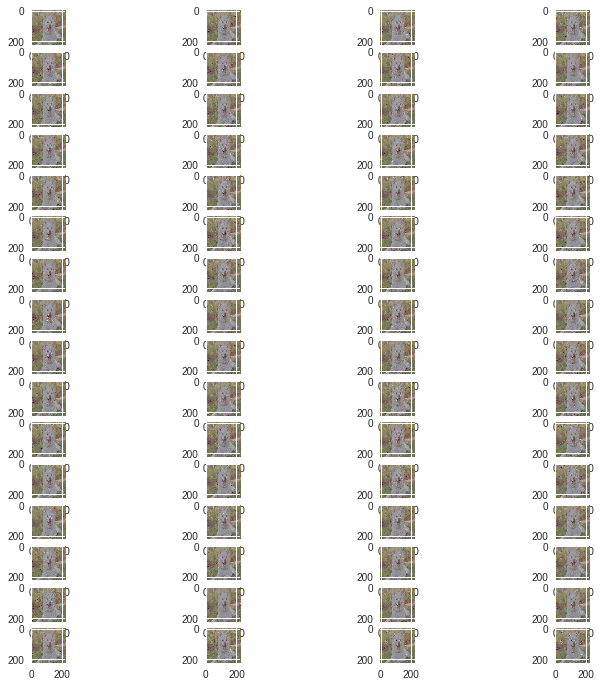

In [36]:
plt.subplots(4,4, figsize=(12,12))
for i in range(len(filters_info)):
  plt.subplot(16,4,i+1)
  #plt.axis('off')
  img_updated = deprocess_image(filters_info[i][1])
  plt.imshow(img_updated, cmap='jet')
  
plt.show()

### Observation

First layer distinguish colours.

Some of the first images seem to have duplicated infomation (same colour). So maybe we can reduce the number of featuremap while keeping the same model performance.